In [3]:
#using PyPlot
using winston
include("sim.jl") #include the simulator 

LoadError: LoadError: ArgumentError: winston not found in path
while loading In[3], in expression starting on line 2

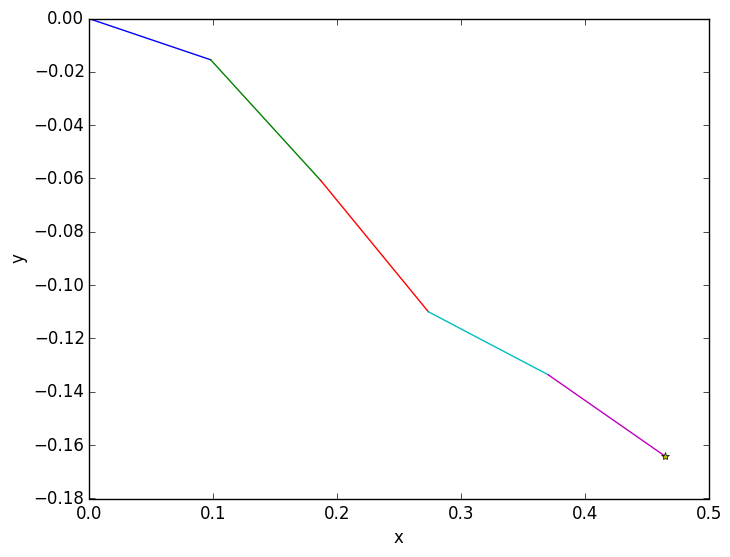

PyObject <matplotlib.text.Text object at 0x0000000035F655F8>

In [8]:
#defne parameters
l=.1 #segment len
n=5 #number of segments 
#k=[.4 -1 1 1 1]
k=rand(n)*10-5
p=makeArm(k, l)
hold("on")
for i=1:n
    plot(p[i:i+1, 1],p[i:i+1, 2])
end
plot(p[end, 1],p[end, 2], "*")
xlabel("x")
ylabel("y")

In [9]:
k

5-element Array{Float64,1}:
 -3.12224
 -3.18714
  2.30027
  3.21984
 -4.68648